In [18]:
import torch
import numpy as np
from preprocess import load_data
from model import GCNModel, loss_fn

import os
import scipy.sparse as sp
from scipy import io
from preprocess import normalize, sparse_mx_to_torch_sparse_tensor

In [19]:
def load_course_data(path="data/course", feature_mode="plain"):
    fnames = os.listdir(path)
    data = []
    for fname in fnames:
        print(fname)
        if fname.startswith("."): continue
        mat = io.mmread(os.path.join(path, fname))
        row, col = mat.nonzero()
        nodes = max(np.max(row), np.max(col))+1
        idx = np.where(row != col)
        row, col = row[idx], col[idx]
        adj = sp.coo_matrix((np.ones(len(row)), (row, col)), shape=mat.shape, dtype=np.float32)
        adj = adj + adj.T
        adj[adj > 0] = 1.
        adj_hat = normalize(adj + sp.eye(adj.shape[0]))
        adj_hat = sparse_mx_to_torch_sparse_tensor(adj_hat)
        if feature_mode == "plain":
            feat = torch.ones(nodes, 1).float()
        else: # feature_mode == "degree":
            feat = torch.Tensor(adj.sum(axis=1)/adj.shape[1]).view(-1,1).float()
            feat = (feat-torch.min(feat))/(torch.max(feat)-torch.min(feat))
        data.append((fname[:-4], feat, adj_hat, adj))
    return data

In [20]:
truth_dict = {
    "662_bus": 306,
    "b2_ss": 544,
    "bcspwr01": 17,
    "bcspwr10": 2576,
    "bcsstk05": 76,
    "can_62": 29,
    "dwt_72": 32,
    "dwt_198": 99,
    "dwt_2680": 1340,
    "G15": 400,
    "G17": 400,
    "lp_e226": 200,
    "lshp_406": 203,
    "msc01440": 720,
    "poli": 792,
    "sphere3": 129,
    "mark3jac020sc": 4554,
    "bayer04": 10238
}

In [21]:
data = load_course_data("data/course", feature_mode="degree")

poli.mtx
.DS_Store
bcspwr10.mtx
msc01440.mtx
G17.mtx
G15.mtx
bcspwr01.mtx
mark3jac020sc.mtx
bayer04.mtx
dwt_198.mtx
bcsstk05.mtx
lshp_406.mtx
can_62.mtx
662_bus.mtx
dwt_72.mtx
b2_ss.mtx
sphere3.mtx
dwt_2680.mtx


In [22]:
model = GCNModel(1, [16], 16, 0.5)
model.load_state_dict(torch.load("model.pt"))
model.eval()

GCNModel(
  (gcnlayers): Sequential(
    (0): GraphConvolutionLayer()
    (1): GraphConvolutionLayer()
  )
  (bilinear): SymmetricBilinearLayer()
)

In [52]:
def sort_idx_unravel(probs):
    count = np.count_nonzero(probs)
    i = probs.argsort(axis = None)[::-1]
    j = np.unravel_index(i, probs.shape)
    idx = np.vstack(j).T[:count]
    return idx[1::2] 

def greedy_matching(idx):
    node = []
    matching_count = 0
    for i in idx:
        u, v = i[0], i[1]
        if u in node or v in node:
            pass
        else:
            node = np.append(node,[u,v])
            matching_count += 1
    return matching_count


In [53]:
opt_gap_dict = {}
for i, (fname, feat, adj_mtx, adj) in enumerate(data):
    print(fname, feat.shape, adj_mtx.shape)
    
    out = model(feat, adj_mtx).data.numpy()
    mask = np.zeros(out.shape)
    mask[adj.nonzero()] = 1.
    out *= mask
    match = greedy_match(sort_idx_unravel(out))
    opt_gap_dict[fname] = (truth_dict[fname]-match) / truth_dict[fname]

print(opt_gap_dict)

poli torch.Size([4008, 1]) torch.Size([4008, 4008])
bcspwr10 torch.Size([5300, 1]) torch.Size([5300, 5300])
msc01440 torch.Size([1440, 1]) torch.Size([1440, 1440])
G17 torch.Size([800, 1]) torch.Size([800, 800])
G15 torch.Size([800, 1]) torch.Size([800, 800])
bcspwr01 torch.Size([39, 1]) torch.Size([39, 39])
mark3jac020sc torch.Size([9129, 1]) torch.Size([9129, 9129])
bayer04 torch.Size([20545, 1]) torch.Size([20545, 20545])
dwt_198 torch.Size([198, 1]) torch.Size([198, 198])
bcsstk05 torch.Size([153, 1]) torch.Size([153, 153])
lshp_406 torch.Size([406, 1]) torch.Size([406, 406])
can_62 torch.Size([62, 1]) torch.Size([62, 62])
662_bus torch.Size([662, 1]) torch.Size([662, 662])
dwt_72 torch.Size([72, 1]) torch.Size([72, 72])
b2_ss torch.Size([1089, 1]) torch.Size([1089, 1089])
sphere3 torch.Size([258, 1]) torch.Size([258, 258])
dwt_2680 torch.Size([2680, 1]) torch.Size([2680, 2680])
{'poli': 0.03156565656565657, 'bcspwr10': 0.06832298136645963, 'msc01440': 0.001388888888888889, 'G17': 

In [54]:
len(opt_gap_dict)
gap = 0.0
for k,v in opt_gap_dict.items():
    gap += v
gap /= len(opt_gap_dict)
print(gap * 100)

3.962342914571489


In [43]:
import matplotlib.pyplot as plt

fname = "data/course/can_62.mtx"
mat = io.mmread(fname)
row, col = mat.nonzero()
nodes = max(np.max(row), np.max(col))
idx = np.where(row != col)
row, col = row[idx], col[idx]
adj = sp.coo_matrix((np.ones(len(row)), (row, col)), shape=mat.shape, dtype=np.float32)
adj = adj + adj.T
adj[adj > 0] = 1.
adj_hat = normalize(adj + sp.eye(adj.shape[0]))
adj_hat = sparse_mx_to_torch_sparse_tensor(adj_hat)

feat = torch.Tensor(adj.sum(axis=1)/adj.shape[1]).view(-1,1).float()
feat = (feat-torch.min(feat))/(torch.max(feat)-torch.min(feat))

print(feat.shape, adj_hat.shape)
out_pre_mask = model(feat, adj_hat).data.numpy()
mask = np.zeros(out_pre_mask.shape)
mask[adj.nonzero()] = 1.
out_post_mask = out_pre_mask * mask

torch.Size([62, 1]) torch.Size([62, 62])


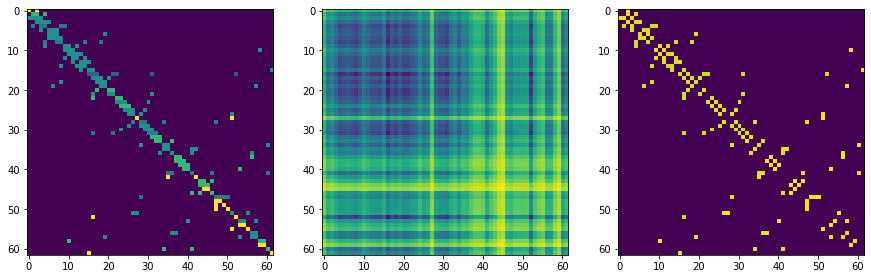

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
axes[0].imshow(adj_hat.to_dense().numpy())
axes[1].imshow(out_pre_mask)
axes[2].imshow(out_post_mask)